## My version of this notebook 

We will be using ray to develop the appplication using distributed workloads

Importing all necessary libraries

In [1]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import ray
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-08-28 16:27:42,354	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.3
Ray version:,2.6.0
Dashboard:,http://127.0.0.1:8265


Since I am going to be running this locally, my cpu will be acting as the node

In [3]:
ray.cluster_resources()

{'object_store_memory': 3072980582.0,
 'memory': 6145961166.0,
 'node:__internal_head__': 1.0,
 'CPU': 16.0,
 'node:10.0.0.77': 1.0}

In [4]:
num_workers = 10
resources_per_worker = {"CPU": 3, "GPU": 1}

### Data Ingestion -> Going through the data and analysing all its aspects

In [5]:
URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(URL)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


Checking whether the data integrity has been maintained by looking for 
null values, checking if all the tags belong in the set of tags that we wanted,etc

In [6]:
df.isna().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

We can see that there are no null values

In [7]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

We can see that the data is as we want it, with all the features we want.
We can move on to the next part

### Data Splitting

In [8]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

The number of content we have for each tag differs, this could cause a bias in the model picking one tag over another, normally in such a case, the model picks the tag that has been shown to it the most. To fix this, we need to fix the way we feed in data, and make sure that we have equal/proprtional features of each in the training and validation set 

In [9]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size)

In [10]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [11]:
val_df.tag.value_counts() * int((1-test_size)/test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

We will now try and understand the data in a deeper fashion

In [12]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

Plotting the tag frequencies

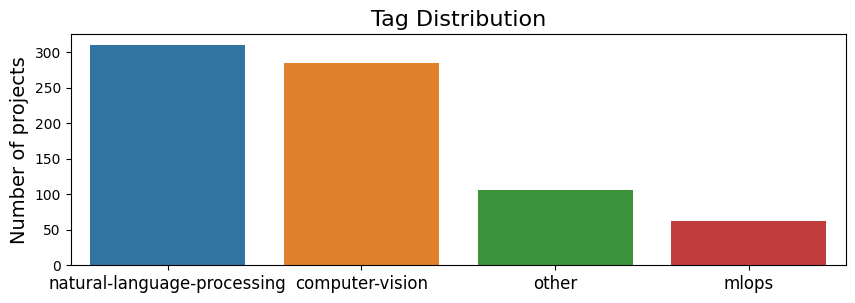

In [13]:
tags,tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags),y=list(tag_counts))
ax.set_xticklabels(tags,rotation=0,fontsize=12)
plt.title("Tag Distribution",fontsize=16)
plt.ylabel("Number of projects",fontsize=14)
plt.show()

There is a huge data imbalance, this would cause issues during the training

Generating a Word cloud

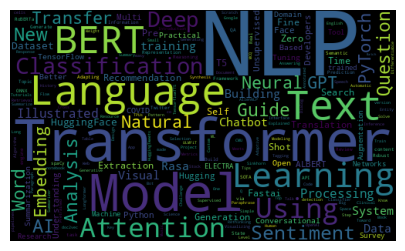

In [14]:
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

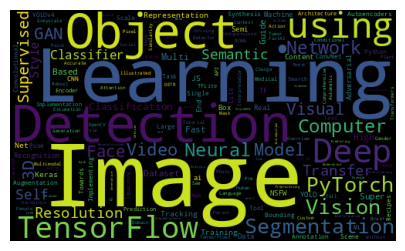

In [17]:
tag = "computer-vision"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

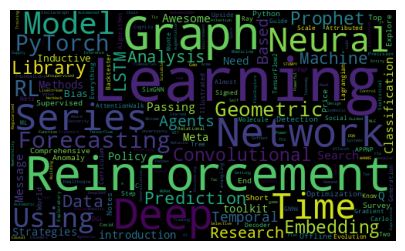

In [18]:
tag = "other"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

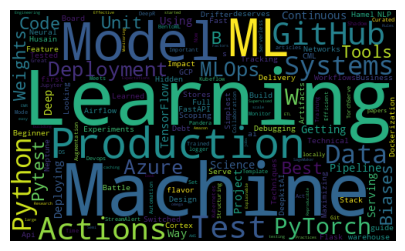

In [19]:
tag = "mlops"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

### Data Preprocessing (feature engineering)

In [20]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [21]:
df["text"] = df.title + " " + df.description

In [22]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/veer/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [25]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [26]:
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Converting our data to numerical values as that is all that is accepted by our model 

In [29]:
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag:i for i,tag in enumerate(tags)}
class_to_index

{'natural-language-processing': 0,
 'computer-vision': 1,
 'other': 2,
 'mlops': 3}

In [30]:
df["tag"] = df['tag'].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,1
1,show infer tell contextual inference creative ...,1
2,awesome graph classification collection import...,2
3,awesome monte carlo tree search curated list m...,2
4,attentionwalk pytorch implementation watch ste...,2


In [31]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Encoding has been completed, we need to tokenize our string data now

In [32]:
import numpy as np 
from transformers import BertTokenizer

In [33]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [34]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))


In [35]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([1])}

### Converting our preprocessing steps into a function 

In [36]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [37]:
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,  9461, 30110, ...,     0,     0,     0],
        [  102,  5800,  5712, ...,     0,     0,     0],
        [  102,   487,   643, ...,     0,     0,     0],
        ...,
        [  102,  2208,  3736, ...,     0,     0,     0],
        [  102, 26954,  3687, ...,     0,     0,     0],
        [  102,  8165, 30108, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 0, 0, 1, 0, 0, 0, 2, 0, 3, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 2,
        2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 3, 1, 1, 0,
        2, 0, 3, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 3, 2, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 2, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        3, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 3, 1, 1, 1, 1, 2, 0, 0, 0,
        1, 2, 0, 0, 1, 1, 1, 0, 3

Repeating the above step but using distributed preprocessing

In [38]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [40]:
# Data ingestion
ds = ray.data.read_csv(URL)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-08-28 16:37:26,339	INFO read_api.py:374 -- To satisfy the requested parallelism of 32, each read task output will be split into 32 smaller blocks.
2023-08-28 16:37:26,348	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-08-28 16:37:26,349	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle]
2023-08-28 16:37:26,350	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-28 16:37:26,350	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

[{'id': 733,
  'created_on': datetime.datetime(2020, 5, 6, 4, 30, 47),
  'title': 'LandCover.ai',
  'description': 'Dataset for automatic mapping of buildings, woodlands and water from aerial imagery.',
  'tag': 'computer-vision'}]

In [41]:
test_size = 0.2
train_ds,val_df = stratify_split(ds,stratify="tag",test_size=test_size)

2023-08-28 16:45:41,230	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-08-28 16:45:41,232	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-28 16:45:41,232	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-08-28 16:46:05,922	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-08-28 16:46:05,922	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-28 16:46:05,923	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2023-08-28 16:46:07,361	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-08-28 16:46:07,362	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-28 16:46:07,363	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/32 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [43]:
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2023-08-28 16:46:28,818	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-08-28 16:46:28,819	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-28 16:46:28,819	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

{'ids': array([  102,  3450,  1183, 30111,  3997,  1904, 23576, 10385,   532,
        2568,   453,   103,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), 'targets': 3}
